---
title: "Example with control"
---

In [1]:
# | include: false
import os

os.environ["USE_PYGEOS"] = "0"


In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ribasim

from pathlib import Path

Set up the nodes:

In [3]:
xy = np.array(
    [
        (0.0, 0.0),  # 1: Basin
        (1.0, -1.0), # 2: LinearResistance
        (2.0, 0.0),   # 3: Basin
        (1.0, 0.0),  # 4: Pump
        (1.0, 1.0),  # 5: Control

    ]
)

node_xy = gpd.points_from_xy(x=xy[:, 0], y=xy[:, 1])

node_type = [
    "Basin",
    "LinearResistance",
    "Basin",
    "Pump",
    "Control",
]

# Make sure the feature id starts at 1: explicitly give an index.
node = ribasim.Node(
    static=gpd.GeoDataFrame(
        data={"type": node_type},
        index=pd.Index(np.arange(len(xy)) + 1, name="fid"),
        geometry=node_xy,
        crs="EPSG:28992",
    )
)

Setup the edges:

In [4]:
from_id = np.array(
    [1,2,1,4,5], dtype=np.int64
)
to_id = np.array(
    [2,3,4,3,4], dtype=np.int64
)

edge_type = 4*["flow"] + ["control"]

lines = ribasim.utils.geometry_from_connectivity(node, from_id, to_id)
edge = ribasim.Edge(
    static=gpd.GeoDataFrame(
        data={"from_node_id": from_id, "to_node_id": to_id,
              "edge_type": edge_type},
        geometry=lines,
        crs="EPSG:28992",
    )
)

Setup the basins:

In [5]:
profile = pd.DataFrame(
    data={
        "node_id": [1,1,3,3],
        "storage": [0.0, 100.0] * 2,
        "area": [100.0, 100.0] * 2,
        "level": [0.0, 1.0] * 2,
    }
)

static = pd.DataFrame(
    data={
        "node_id": [1,3],
        "drainage": [0.0] * 2,
        "potential_evaporation": [0.0] * 2,
        "infiltration": [0.0] * 2,
        "precipitation": [0.0] * 2,
        "urban_runoff": [0.0] * 2,
    }
)

state = pd.DataFrame(
    data={
        "node_id": [1,3],
        "storage": [100.0, 0.0]
    }
)

basin = ribasim.Basin(profile=profile, static=static, state=state)

Setup the control:

In [6]:
condition = pd.DataFrame(
    data={
        "node_id": [5,5],
        "listen_node_id": [1,3],
        "variable": ["level","level"],
        "greater_than": [0.8,0.4],
    }
)

# False, False -> "on" 
# True,  False -> "off"
# False, True  -> "off" 
# True,  True  -> "On"

# Truth state as subset of the conditions above and in that order

logic = pd.DataFrame(
    data={
        "node_id":[5,5,5,5],
        "truth_state":["FF", "TF", "FT", "TT"],
        "control_state":["on","off", "off", "on"],
    }
)

control = ribasim.Control(condition = condition, logic=logic)

Setup the pump:

In [7]:
pump = ribasim.Pump(
    static=pd.DataFrame(
        data={
            "control_state": ["off", "on"],
            "node_id": [4,4],
            "flow_rate": [0.0, 1e-5],
        }
    )
)

Setup the linear resistance:

In [8]:
linear_resistance = ribasim.LinearResistance(
    static=pd.DataFrame(
        data={
            "node_id": [2],
            "resistance": [1e5],
        }
    )
)

Setup a model:

In [9]:
model = ribasim.Model(
    modelname="control",
    node=node,
    edge=edge,
    basin=basin,
    linear_resistance=linear_resistance,
    pump=pump,
    control=control,
    starttime="2020-01-01 00:00:00",
    endtime="2021-01-01 00:00:00",
)

<Axes: >

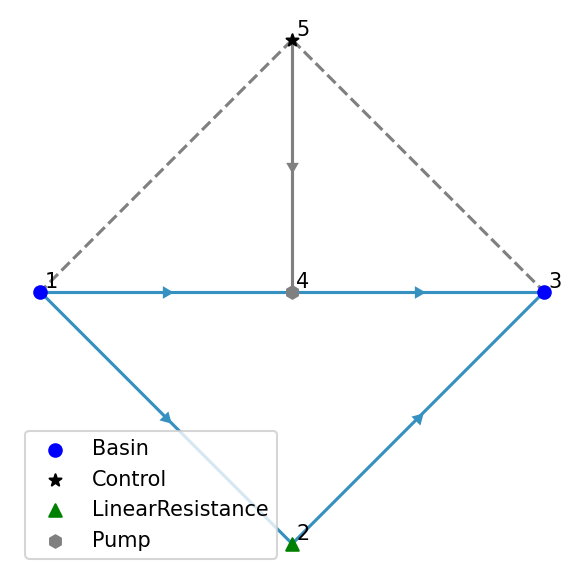

In [10]:
fig, ax = plt.subplots(dpi = 150)
ax.axis("off")

model.plot(ax=ax)

In [11]:
datadir = Path("data")
model.write(datadir / "control")

In [12]:
# | include: false
from subprocess import run

run(
    [
        "julia",
        "--project=../../core",
        "--eval",
        f'using Ribasim; Ribasim.run("{datadir.as_posix()}/control/control.toml")',
    ],
    check=True,
)

CompletedProcess(args=['julia', '--project=../../core', '--eval', 'using Ribasim; Ribasim.run("data/control/control.toml")'], returncode=0)

Text(0.5, 1.0, 'With control')

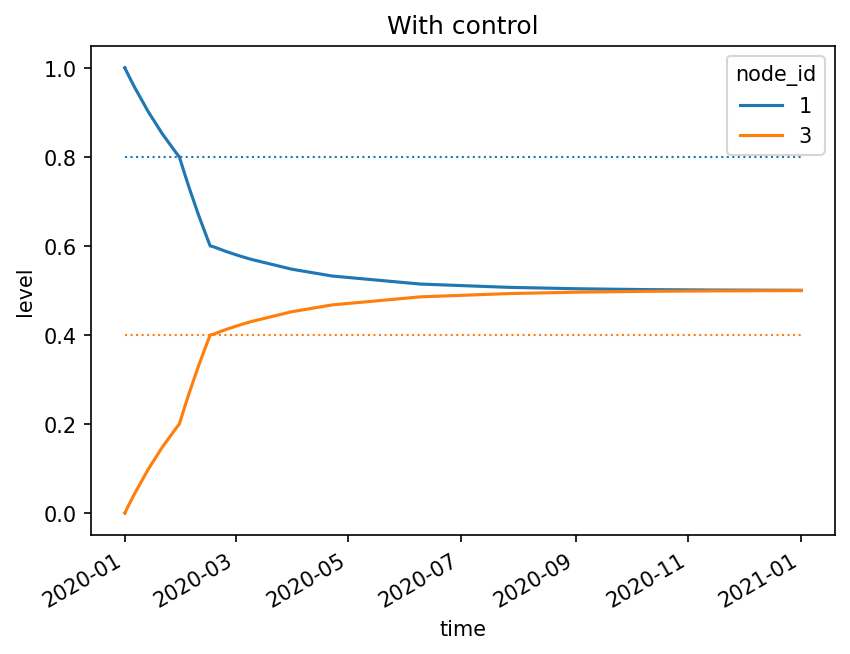

In [13]:
df_basin = pd.read_feather(datadir / "control/output/basin.arrow")
df_basin_wide = df_basin.pivot_table(
    index="time", columns="node_id", values=["storage", "level"]
)

fig, ax = plt.subplots(dpi = 150)

df_basin_wide["level"].plot(ax = ax)

ax.hlines([0.4,0.8], df_basin.time[0], df_basin.time.max(), color = ["C1", "C0"], lw = 1, ls = ":")
ax.set_ylabel("level")
ax.set_title("With control")

In [18]:
model.edge.static

,from_node_id,to_node_id,edge_type,geometry
0,1,2,flow,"LINESTRING (0.000 0.000, 1.000 -1.000)"
1,2,3,flow,"LINESTRING (1.000 -1.000, 2.000 0.000)"
2,1,4,flow,"LINESTRING (0.000 0.000, 1.000 0.000)"
3,4,3,flow,"LINESTRING (1.000 0.000, 2.000 0.000)"
4,5,4,control,"LINESTRING (1.000 1.000, 1.000 0.000)"


In [20]:
model.pump.static

,remarks,flow_rate,node_id,control_state
0,,0.00000,4,off
1,,0.00001,4,on


In [15]:
model.control.condition

,remarks,listen_node_id,greater_than,node_id,variable
0,,1,0.8,5,level
1,,3,0.4,5,level


In [16]:
model.control.logic

,remarks,truth_state,node_id,control_state
0,,FF,5,on
1,,TF,5,off
2,,FT,5,off
3,,TT,5,on
